In [31]:
import os, sys
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
import random
from collections import defaultdict, Counter
import matplotlib.image as mpimg
from skimage.transform import resize
from PIL import Image
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout, concatenate
from tensorflow.keras.models import Model
import matplotlib.image as mpimg

Plutôt que charger directement les images, on fait un dataframe qui va stocker les chemins des images, les artistes, les longueurs et les largeurs (le chargement réél des images se fera juste avant l'entraînement par des fonctions optimisées de Tensorflow).

In [2]:
path = os.path.join(os.getcwd(), "art-challenge", "images_lq")

# Initialize a list to store image data
data = []

# Loop through each image in the folder
for image_file in os.listdir(path):
    # Separate artist from the rest of the file name (remove the extension)
    artist = '_'.join(image_file.split('_')[:-1])  # Get everything before the last underscore "_"
    
    # Get image path and open lazily to access dimensions
    img_path = os.path.join(path, image_file)
    with Image.open(img_path) as img:
        width, height = img.size  # Get image dimensions without fully loading it
    
    # Append image details to the data list
    data.append({
        'image_path': img_path,
        'artist': artist,
        'width': width,
        'height': height
    })

# Create a DataFrame with the collected data
df_images = pd.DataFrame(data)

On affiche des images au hasard avec leurs artistes

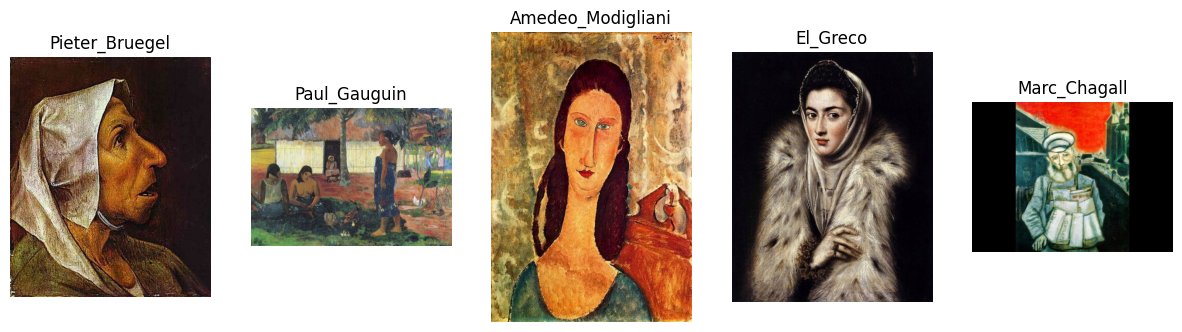

In [3]:
random_indices = random.sample(range(len(df_images)), 5)

# Créer une figure avec 5 sous-graphes
fig, axs = plt.subplots(1, 5, figsize=(15, 5))

# Afficher les images avec leurs noms d'artistes
for i, idx in enumerate(random_indices):
    # Lire l'image à partir du chemin dans le DataFrame
    img = Image.open(df_images.loc[idx, 'image_path']).convert('RGB')
    
    # Afficher l'image et le nom de l'artiste
    axs[i].imshow(img)
    axs[i].set_title(df_images.loc[idx, 'artist'])  # Titre avec le nom de l'artiste
    axs[i].axis('off')  # Masquer les axes

plt.show()

Histogramme du nombre d'images par artistes dans l'ordre décroissant. On trace les quantiles à 25% et 75% (en dessous du rouge se trouvent les 25% d'artistes ayant le moins d'images et au-dessus du vert les 25% ayant le plus). 

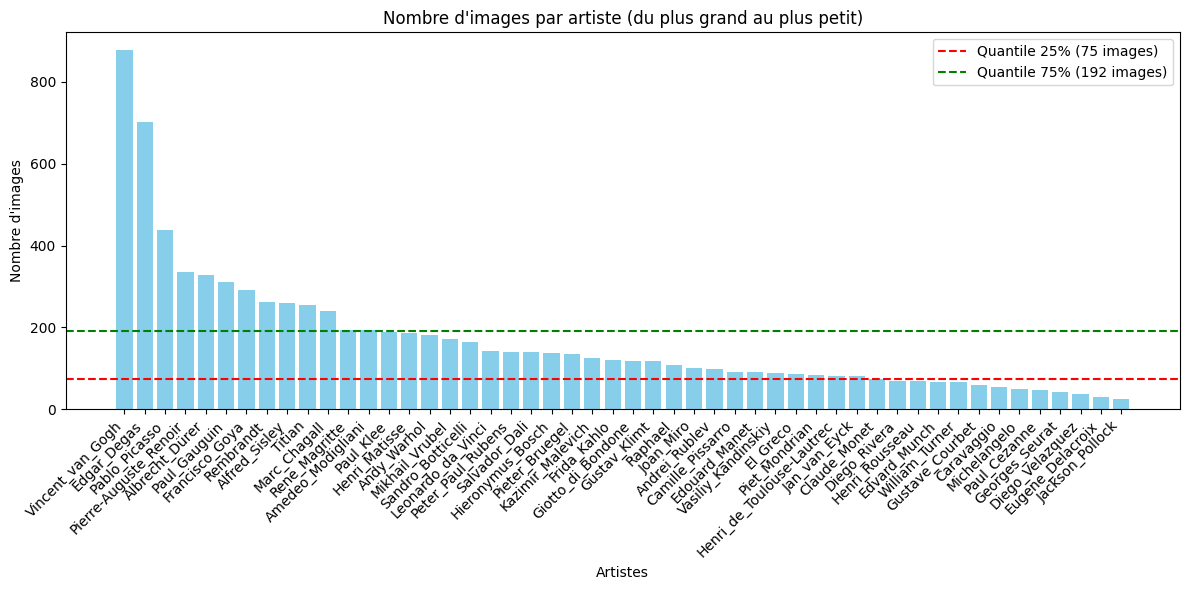

In [4]:
def histogramme_images_par_artiste(df,quantile=True):
    """
    Affiche un histogramme du nombre d'images par artiste, trié du plus grand au plus petit,
    avec des lignes indiquant les quantiles à 25% et 75% du nombre d'images.

    Args:
    - df: DataFrame contenant au moins une colonne 'artist' avec les noms des artistes.
    """
    # Compter le nombre d'images pour chaque artiste
    compte_artistes = Counter(df['artist'])

    # Trier les artistes par nombre d'images, du plus grand au plus petit
    artistes_tries = sorted(compte_artistes.items(), key=lambda x: x[1], reverse=True)
    noms_artistes = [artiste for artiste, _ in artistes_tries]
    nombre_images = [nb_images for _, nb_images in artistes_tries]

    # Calculer les quantiles à 25% et 75% du nombre d'images par artiste
    quantile_25 = np.percentile(nombre_images, 25)
    quantile_75 = np.percentile(nombre_images, 75)

    # Créer l'histogramme
    plt.figure(figsize=(12, 6))
    plt.bar(noms_artistes, nombre_images, color='skyblue')

    # Ajouter des lignes horizontales pour les quantiles à 25% et 75%
    if quantile:
        plt.axhline(quantile_25, color='red', linestyle='--', linewidth=1.5, label=f'Quantile 25% ({quantile_25:.0f} images)')
        plt.axhline(quantile_75, color='green', linestyle='--', linewidth=1.5, label=f'Quantile 75% ({quantile_75:.0f} images)')
        
    plt.xticks(rotation=45, ha='right')

    # Ajouter les labels, le titre et la légende
    plt.xlabel('Artistes')
    plt.ylabel('Nombre d\'images')
    plt.title('Nombre d\'images par artiste (du plus grand au plus petit)')
    plt.legend()

    # Afficher l'histogramme
    plt.tight_layout()  # Pour ajuster l'espacement et éviter les chevauchements
    plt.show()

# Utilisation du code avec le DataFrame df_images
histogramme_images_par_artiste(df_images)

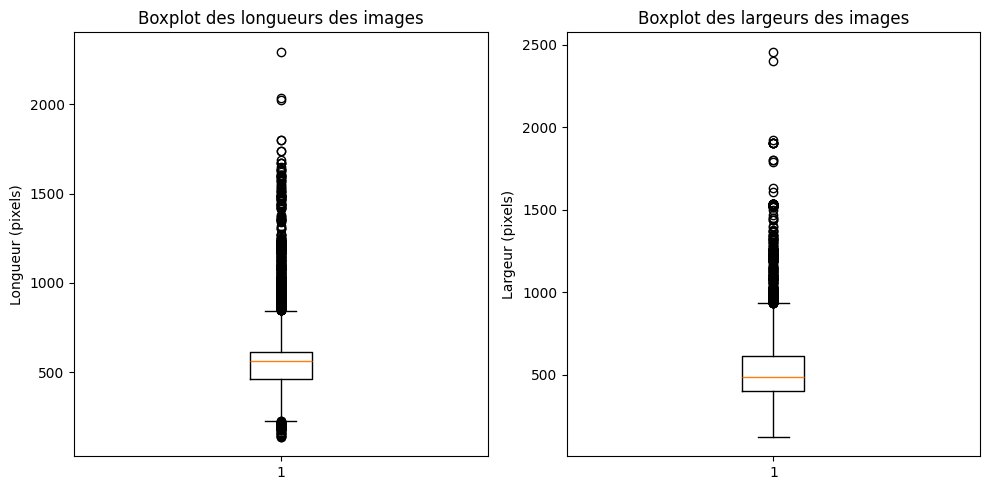

In [5]:
def boxplot_dimensions_images(df):
    """
    Affiche un boxplot des longueurs et des largeurs des images dans le DataFrame.

    Args:
    - df: DataFrame contenant les colonnes 'width' et 'height' pour les dimensions des images.
    """
    # Extraire les longueurs et largeurs des images à partir du DataFrame
    longueurs = df['height']
    largeurs = df['width']

    # Créer un boxplot pour les longueurs et largeurs
    plt.figure(figsize=(10, 5))

    # Boxplot pour les longueurs
    plt.subplot(1, 2, 1)
    plt.boxplot(longueurs)
    plt.title('Boxplot des longueurs des images')
    plt.ylabel('Longueur (pixels)')

    # Boxplot pour les largeurs
    plt.subplot(1, 2, 2)
    plt.boxplot(largeurs)
    plt.title('Boxplot des largeurs des images')
    plt.ylabel('Largeur (pixels)')

    # Afficher les boxplots
    plt.tight_layout()
    plt.show()

# Utilisation du code avec le DataFrame df_images
boxplot_dimensions_images(df_images)

/tmp/ipykernel_441374/452129405.py:35: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(longueurs, labels=artistes_ordonnes)
/tmp/ipykernel_441374/452129405.py:42: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(largeurs, labels=artistes_ordonnes)


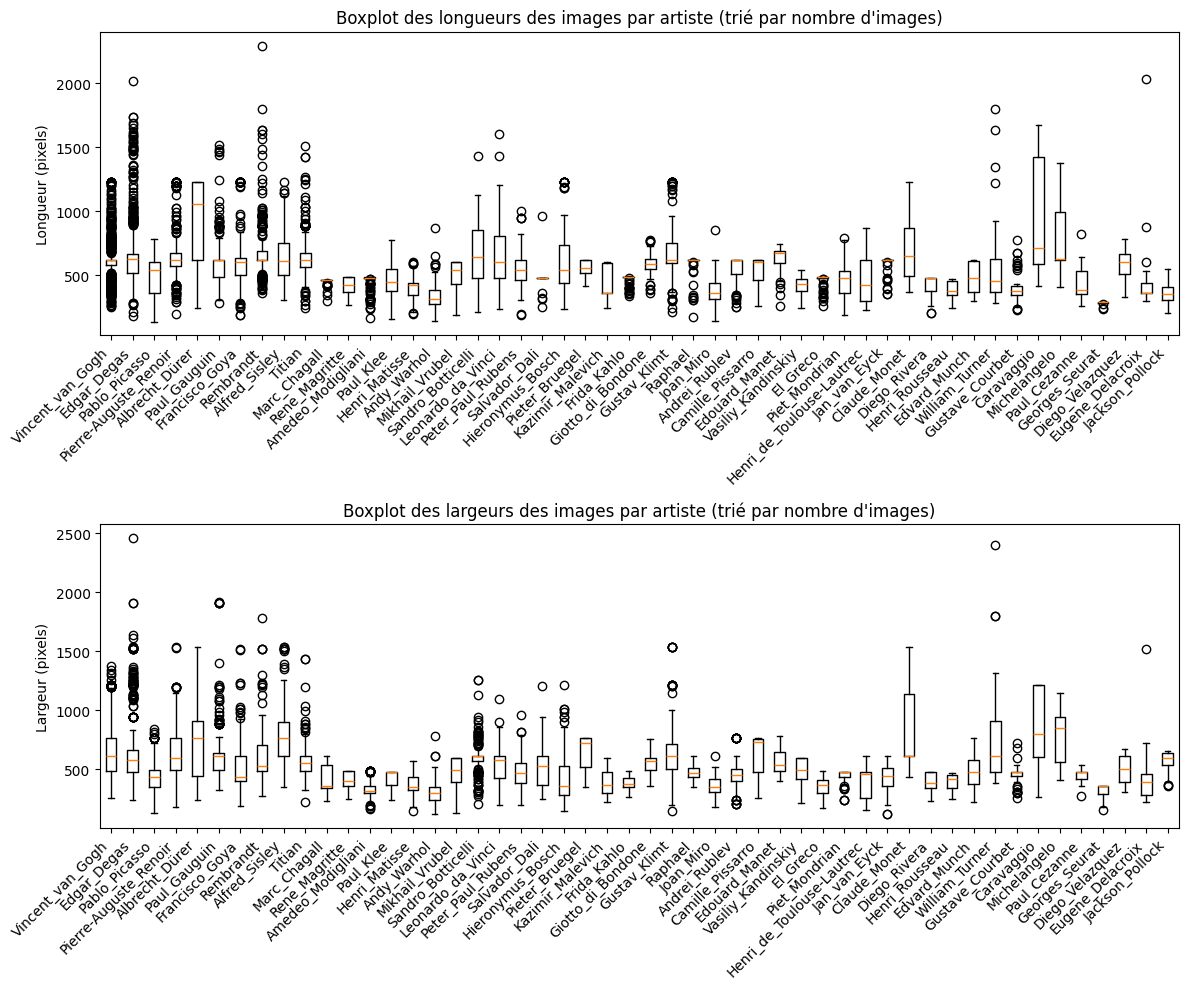

In [6]:
def boxplot_dimensions_par_artiste(df):
    """
    Affiche des boxplots des longueurs et largeurs des images pour chaque artiste,
    trié par ordre décroissant du nombre d'images.

    Args:
    - df: DataFrame contenant les colonnes 'artist', 'width', et 'height'.
    """
    # Initialiser des dictionnaires pour stocker les longueurs et largeurs par artiste
    longueurs_par_artiste = defaultdict(list)
    largeurs_par_artiste = defaultdict(list)

    # Remplir les longueurs et largeurs par artiste
    for _, row in df.iterrows():
        artiste = row['artist']
        longueurs_par_artiste[artiste].append(row['height'])  # Hauteur des images
        largeurs_par_artiste[artiste].append(row['width'])    # Largeur des images

    # Compter le nombre d'images pour chaque artiste
    compte_artistes = Counter(df['artist'])

    # Trier les artistes par nombre d'images, du plus grand au plus petit
    artistes_tries = sorted(compte_artistes.items(), key=lambda x: x[1], reverse=True)
    artistes_ordonnes = [artiste for artiste, _ in artistes_tries]

    # Récupérer les longueurs et largeurs triées par artiste
    longueurs = [longueurs_par_artiste[artiste] for artiste in artistes_ordonnes]
    largeurs = [largeurs_par_artiste[artiste] for artiste in artistes_ordonnes]

    # Créer une figure plus grande et étalée
    plt.figure(figsize=(12, 10))  # Augmenter la taille verticale

    # Boxplot pour les longueurs par artiste (en haut)
    plt.subplot(2, 1, 1)  # 2 lignes, 1 colonne, 1er subplot
    plt.boxplot(longueurs, labels=artistes_ordonnes)
    plt.xticks(rotation=45, ha='right')
    plt.title('Boxplot des longueurs des images par artiste (trié par nombre d\'images)')
    plt.ylabel('Longueur (pixels)')

    # Boxplot pour les largeurs par artiste (en bas)
    plt.subplot(2, 1, 2)  # 2 lignes, 1 colonne, 2e subplot
    plt.boxplot(largeurs, labels=artistes_ordonnes)
    plt.xticks(rotation=45, ha='right')
    plt.title('Boxplot des largeurs des images par artiste (trié par nombre d\'images)')
    plt.ylabel('Largeur (pixels)')

    # Ajuster la disposition et afficher
    plt.tight_layout()
    plt.show()

# Utilisation du code avec le DataFrame df_images
boxplot_dimensions_par_artiste(df_images)

In [7]:
num_images = len(df_images)
num_artists = df_images['artist'].nunique()

print(f"Nombre d'images dans le DataFrame: {num_images}")
print(f"Nombre d'artistes uniques dans le DataFrame: {num_artists}")

Nombre d'images dans le DataFrame: 8355
Nombre d'artistes uniques dans le DataFrame: 50


On retire les artistes ayant moins de 75 images (sous la barre rouge de l'histogramme) et on autorise 200 images max par artistes (on retire aléaoirement des images pour ceux qui ont en trop).

In [8]:
def filter_artists(df, min_images=75, max_images=200):
    """
    Filtre le DataFrame en conservant uniquement les artistes ayant au moins 'min_images' images
    et réduit aléatoirement le nombre d'images à 'max_images' si un artiste en a plus.
    
    Args:
    - df: DataFrame contenant au moins une colonne 'artist' avec les noms des artistes.
    - min_images: Nombre minimum d'images qu'un artiste doit avoir pour être inclus.
    - max_images: Nombre maximum d'images autorisées par artiste. Si dépassé, des images sont retirées.

    Returns:
    - filtered_df: Nouveau DataFrame filtré.
    """
    # Compter le nombre d'images par artiste
    compte_artistes = Counter(df['artist'])

    # Filtrer les artistes ayant au moins 'min_images' images
    artists_to_keep = [artist for artist, count in compte_artistes.items() if count >= min_images]
    filtered_df = df[df['artist'].isin(artists_to_keep)].copy()

    # Réduire aléatoirement le nombre d'images des artistes ayant plus de 'max_images' images
    filtered_df = filtered_df.groupby('artist').apply(lambda x: x.sample(n=min(len(x), max_images), random_state=42)).reset_index(drop=True)

    return filtered_df

df_images_filtre = filter_artists(df_images)

/tmp/ipykernel_441374/3315996065.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  filtered_df = filtered_df.groupby('artist').apply(lambda x: x.sample(n=min(len(x), max_images), random_state=42)).reset_index(drop=True)


/tmp/ipykernel_441374/911033346.py:36: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


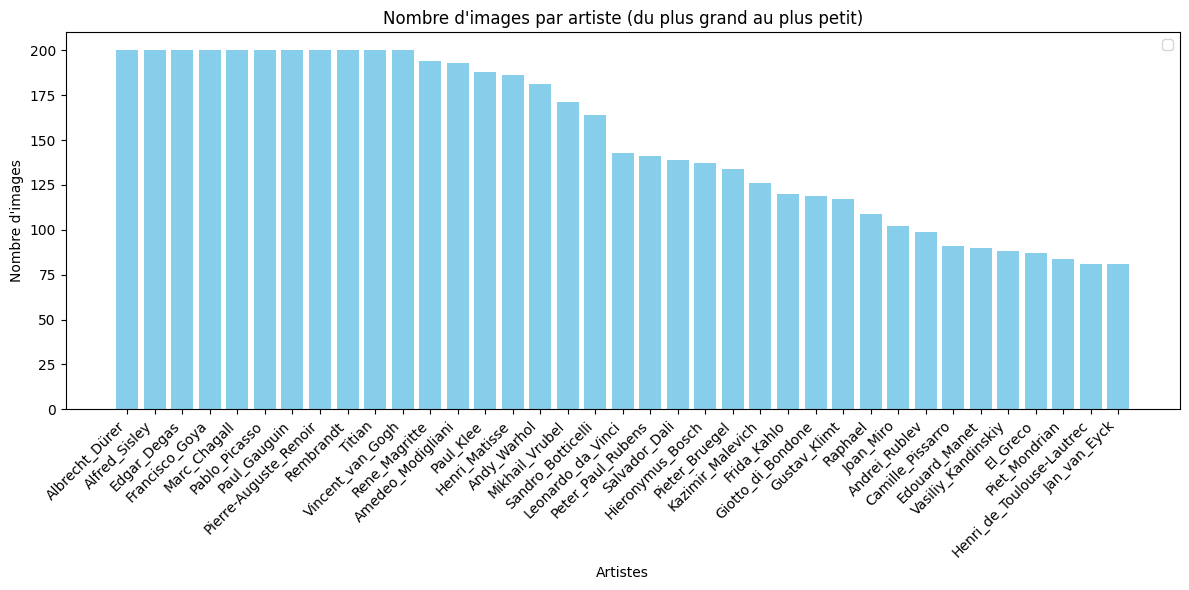

In [9]:
histogramme_images_par_artiste(df_images_filtre,False)

In [10]:
num_images = len(df_images_filtre)
num_artists = df_images_filtre['artist'].nunique()

print(f"Nombre d'images dans le DataFrame: {num_images}")
print(f"Nombre d'artistes uniques dans le DataFrame: {num_artists}")

Nombre d'images dans le DataFrame: 5565
Nombre d'artistes uniques dans le DataFrame: 37


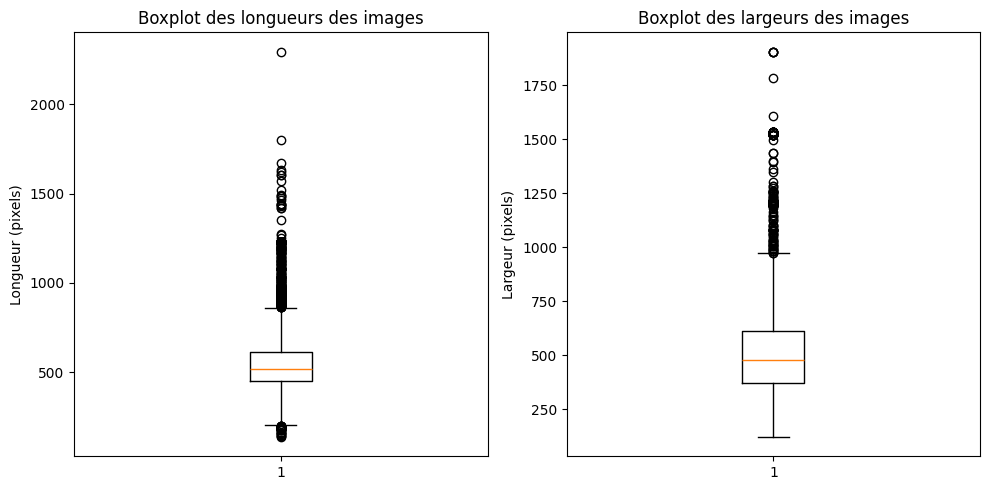

In [11]:
boxplot_dimensions_images(df_images_filtre)

On va split le data_frame en data_train et data_test pour ensuite charger les images en faisant de la data augmentation seulement sur data_train

In [12]:
df = df_images_filtre
test_size = 0.3


label_encoder = LabelEncoder()
df['artist_encoded'] = label_encoder.fit_transform(df['artist'])

# Diviser les données en ensembles d'entraînement et de test
train_df, test_df = train_test_split(df, test_size=test_size, random_state=42, stratify=df['artist_encoded'])

On calcule les poids des classes (si plus tard on a envie d'entraîner avec une loss qui dépend de la place qui prend chaque classe dans le data set).

In [13]:
# Calculer les poids des classes en fonction de la colonne 'artist_encoded'
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(df['artist_encoded']), y=df['artist_encoded'])

# Convertir les poids en un dictionnaire pour un accès facile
class_weights_dict = dict(enumerate(class_weights))

class_weights_dict

{0: 0.7520270270270271,
 1: 0.7520270270270271,
 2: 0.779302618680857,
 3: 1.5192465192465192,
 4: 0.8309690906375989,
 5: 1.6528066528066527,
 6: 0.7520270270270271,
 7: 1.6711711711711712,
 8: 1.7287977632805218,
 9: 0.7520270270270271,
 10: 1.2533783783783783,
 11: 1.2639109697933226,
 12: 1.2855162855162856,
 13: 0.8086312118570184,
 14: 1.8568568568568569,
 15: 1.0978496744920103,
 16: 1.8568568568568569,
 17: 1.4745627980922098,
 18: 1.1936936936936937,
 19: 1.0517860517860518,
 20: 0.7520270270270271,
 21: 0.8795637743006164,
 22: 0.7520270270270271,
 23: 0.7520270270270271,
 24: 0.8000287521564118,
 25: 1.0667050028752156,
 26: 0.7520270270270271,
 27: 1.7905405405405406,
 28: 1.1224283985478016,
 29: 1.3798661046367469,
 30: 0.7520270270270271,
 31: 0.7752855948732238,
 32: 1.0820532762978805,
 33: 0.9171061305207646,
 34: 0.7520270270270271,
 35: 1.7091523341523343,
 36: 0.7520270270270271}

On prépare le data set pour l'entraînement en chargeant les images mises à la bonne taille et normalisées avec ImageDataGenerator (on fait une data augmentation sur data_train)

In [14]:
img_size = (256,256)
test_size = 0.3
batch_size = 20 #tensorflow charge déjà les données par batch pour optimiser la mémoire


train_datagen = ImageDataGenerator(
    rotation_range = 40,
    rescale = 1./255,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode='nearest'
)


# Générateur pour l'ensemble de test (sans augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)


# Préparer les générateurs d'images pour l'entraînement et le test
train_gen = train_datagen.flow_from_dataframe(
    train_df,
    x_col='image_path',
    y_col='artist_encoded',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='raw',
    shuffle=True
)


test_gen = test_datagen.flow_from_dataframe(
    test_df,
    x_col='image_path',
    y_col='artist_encoded',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='raw',
    shuffle=False
)

Found 3895 validated image filenames.
Found 1670 validated image filenames.


In [15]:
input_shape = (256, 256, 3)  # Dimensions des images redimensionnées
num_classes = len(label_encoder.classes_)  # Nombre de classes d'artistes

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

# Compilation du modèle
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Affichage de la structure du modèle
model.summary()

/home/regnie/.conda/envs/tensorflow/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 37)             │         9,509 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,673,125 (25.46 MB)

 Trainable params: 6,673,125 (25.46 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
epochs = 20

# Utilisation d'un EarlyStopping pour arrêter l'entraînement si la validation loss n'améliore plus
#early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

#Entraînement du modèle
#history = model.fit(
#    train_gen,
#    validation_data=test_gen,
#    epochs=epochs,
#    batch_size=batch_size,
#    class_weight = class_weights_dict
#)

Entraînement en cours sur un screen (code dans programme.py) => résultats nuls !

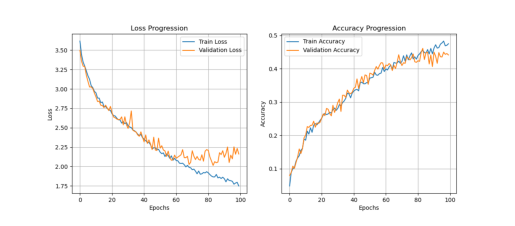

In [32]:
img = mpimg.imread("training_progress1.png")  # Remplacez par le nom de votre image
plt.imshow(img)
plt.axis('off')  # Optionnel, pour enlever les axes
plt.show()

On essaye d'inclure les nationalités

In [17]:
artist_nationalities_path = 'art-challenge/artists.csv'
artist_nationalities_df = pd.read_csv(artist_nationalities_path)

In [18]:
df_images_nationalites = df_images

In [19]:
# Nettoyer et standardiser les noms d'artistes pour correspondre à la colonne "name" dans le CSV
df_images_nationalites['artist_cleaned'] = df_images_nationalites['artist'].str.replace('_', ' ')

# Fusionner les données en utilisant les noms des artistes pour ajouter la première nationalité
# en séparant au cas où plusieurs nationalités sont listées
artist_nationalities_df['nationality'] = artist_nationalities_df['nationality'].str.split(',').str[0]
df_images_nationalites = df_images_nationalites.merge(artist_nationalities_df[['name', 'nationality']], 
                            how='left', 
                            left_on='artist_cleaned', 
                            right_on='name')

# Supprimer les colonnes temporaires
df_images_nationalites.drop(columns=['artist_cleaned', 'name'], inplace=True)

# Afficher le DataFrame mis à jour pour confirmer la nationalité unique par artist


In [20]:
df_images_nationalites

,image_path,artist,width,height,nationality
0,/home/regnie/Bureau/5A/Projets/Mini-projet CNN...,Albrecht_Dürer,432,614,German
1,/home/regnie/Bureau/5A/Projets/Mini-projet CNN...,Albrecht_Dürer,896,1229,German
2,/home/regnie/Bureau/5A/Projets/Mini-projet CNN...,Albrecht_Dürer,402,614,German
3,/home/regnie/Bureau/5A/Projets/Mini-projet CNN...,Albrecht_Dürer,292,461,German
4,/home/regnie/Bureau/5A/Projets/Mini-projet CNN...,Albrecht_Dürer,910,1229,German
...,...,...,...,...,...
8350,/home/regnie/Bureau/5A/Projets/Mini-projet CNN...,William_Turner,600,445,British
8351,/home/regnie/Bureau/5A/Projets/Mini-projet CNN...,William_Turner,664,437,British
8352,/home/regnie/Bureau/5A/Projets/Mini-projet CNN...,William_Turner,614,455,British
8353,/home/regnie/Bureau/5A/Projets/Mini-projet CNN...,William_Turner,480,317,British


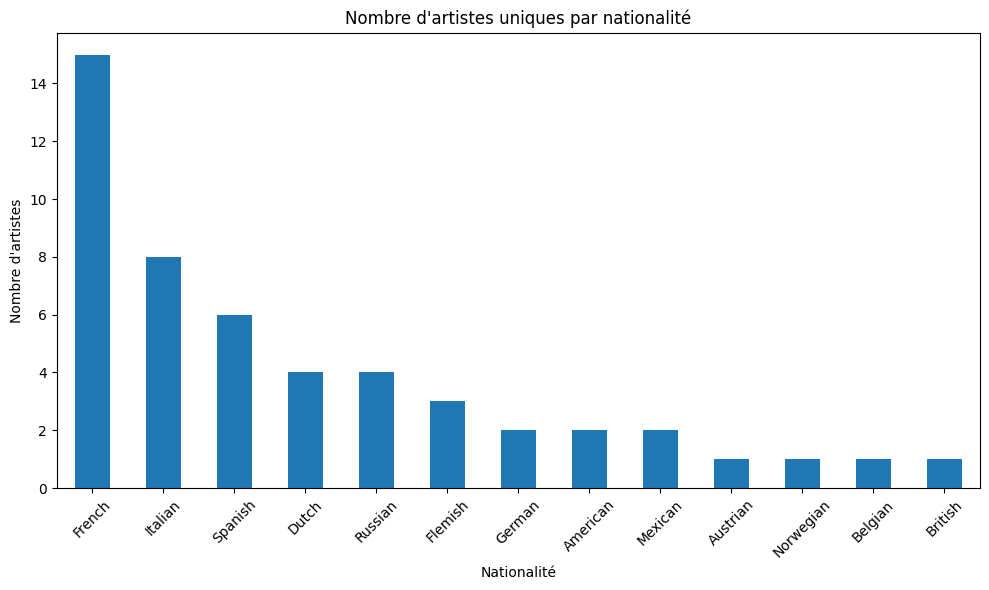

In [21]:
# Compter le nombre d'artistes uniques par nationalité

unique_artists_by_nationality = df_images_nationalites[['artist', 'nationality']].drop_duplicates()
nationality_counts = unique_artists_by_nationality['nationality'].value_counts().sort_values(ascending=False)



# Créer un histogramme

plt.figure(figsize=(10, 6))
nationality_counts.plot(kind='bar')
plt.title("Nombre d'artistes uniques par nationalité")
plt.xlabel("Nationalité")
plt.ylabel("Nombre d'artistes")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/tmp/ipykernel_441374/911033346.py:36: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


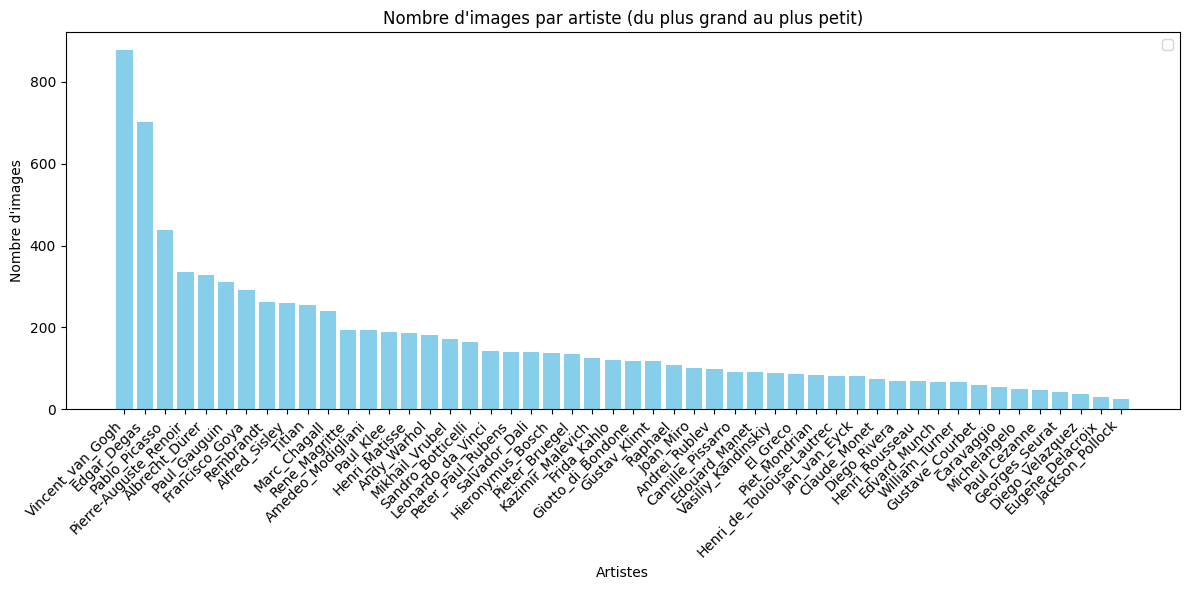

In [22]:
histogramme_images_par_artiste(df_images_nationalites,False)

In [23]:
df_images_nationalites_filtre = filter_artists(df_images_nationalites)

/tmp/ipykernel_441374/3315996065.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  filtered_df = filtered_df.groupby('artist').apply(lambda x: x.sample(n=min(len(x), max_images), random_state=42)).reset_index(drop=True)


/tmp/ipykernel_441374/911033346.py:36: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


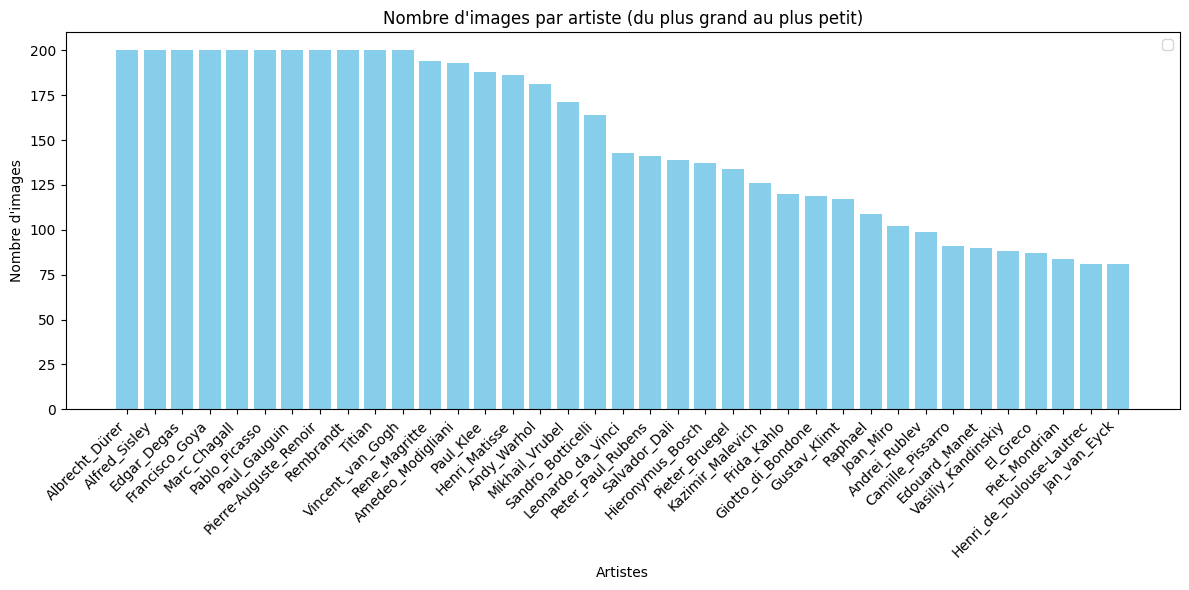

In [24]:
histogramme_images_par_artiste(df_images_nationalites_filtre,False)

In [25]:
print(df_images_nationalites_filtre.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5565 entries, 0 to 5564
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   image_path   5565 non-null   object
 1   artist       5565 non-null   object
 2   width        5565 non-null   int64 
 3   height       5565 non-null   int64 
 4   nationality  5565 non-null   object
dtypes: int64(2), object(3)
memory usage: 217.5+ KB
None


In [26]:
df = df_images_nationalites_filtre

label_encoder = LabelEncoder()
df['artist_encoded'] = label_encoder.fit_transform(df['artist'])

nationality_encoder = LabelEncoder()
df['nationality_encoded'] = nationality_encoder.fit_transform(df['nationality'])

# Diviser les données en ensembles d'entraînement et de test
train_df, test_df = train_test_split(df, test_size=test_size, random_state=42, stratify=df['artist_encoded'])

In [27]:
# Générateur de données avec signature de sortie pour TensorFlow
def custom_data_generator(dataframe, datagen, batch_size, img_size, nationality_col, artist_col, augment=False):
    # Définir les types et formes pour la sortie
    output_signature = (
        {
            'image_input': tf.TensorSpec(shape=(None, *img_size), dtype=tf.float32),
            'nationality_input': tf.TensorSpec(shape=(None, 1), dtype=tf.int64),
        },
        tf.TensorSpec(shape=(None,), dtype=tf.int64)
    )
    
    def generator():
        while True:
            # Génère les données batch par batch
            batch = dataframe.sample(n=batch_size)
            images = []
            nationalities = []
            artists = []

            for _, row in batch.iterrows():
                # Charger et éventuellement augmenter l'image
                img = tf.keras.preprocessing.image.load_img(row['image_path'], target_size=img_size)
                img = tf.keras.preprocessing.image.img_to_array(img)
                
                if augment:
                    img = datagen.random_transform(img)
                
                img = img / 255.0  # Normalisation
                images.append(img)
                
                # Nationalité et artiste
                nationalities.append(row[nationality_col])
                artists.append(row[artist_col])

            # Convertir en tableau numpy et structurer comme un dictionnaire d'entrées
            yield {'image_input': np.array(images), 'nationality_input': np.array(nationalities).reshape(-1, 1)}, np.array(artists)

    # Utiliser le générateur avec une signature de sortie
    return tf.data.Dataset.from_generator(generator, output_signature=output_signature)


# Générateur d'entraînement avec augmentation
train_gen = custom_data_generator(
    dataframe=train_df,
    datagen=train_datagen,
    batch_size=batch_size,
    img_size=img_size,
    nationality_col='nationality_encoded',
    artist_col='artist_encoded',
    augment=True
)

# Générateur de test sans augmentation
test_gen = custom_data_generator(
    dataframe=test_df,
    datagen=test_datagen,
    batch_size=batch_size,
    img_size=img_size,
    nationality_col='nationality_encoded',
    artist_col='artist_encoded',
    augment=False
)


In [28]:
# Paramètres du modèle
img_size = (256, 256, 3)
num_artists = df['artist_encoded'].nunique()

# Entrée Image
image_input = Input(shape=img_size, name='image_input')
x = Conv2D(32, (3, 3), activation='relu')(image_input)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)

# Entrée Nationalité
nationality_input = Input(shape=(1,), name='nationality_input')
y = Dense(32, activation='relu')(nationality_input)

# Fusion des Caractéristiques
combined = concatenate([x, y])

# Couches Denses pour la Prédiction
z = Dense(64, activation='relu')(combined)
z = Dense(128, activation='relu')(z)
output = Dense(num_artists, activation='softmax', name='artist_output')(z)

# Modèle Final
model = Model(inputs=[image_input, nationality_input], outputs=output)

# Compilation du Modèle
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Afficher le Résumé du Modèle
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 254, 254,  │        896 │ image_input[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 127, 127,  │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 125, 125,  │     18,496 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 62, 62,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 60, 60,    │     73,856 │ max_pooling2d_5[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 30, 30,    │          0 │ conv2d_6[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 28, 28,    │    147,584 │ max_pooling2d_6[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 14, 14,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 25088)     │          0 │ max_pooling2d_7[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256)       │  6,422,784 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ nationality_input   │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 32)        │         64 │ nationality_inpu… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 288)       │          0 │ dropout_1[0][0],  │
│ (Concatenate)       │                   │            │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │     18,496 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 128)       │      8,320 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ artist_output       │ (None, 37)        │      4,773 │ dense_5[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,695,269 (25.54 MB)

 Trainable params: 6,695,269 (25.54 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
# Paramètres d'entraînement
epochs = 20

# Entraînement
#model.fit(
#    train_gen,
#    steps_per_epoch=len(train_df) // batch_size,
#    validation_data=test_gen,
#    validation_steps=len(test_df) // batch_size,
#    epochs=epochs
#)

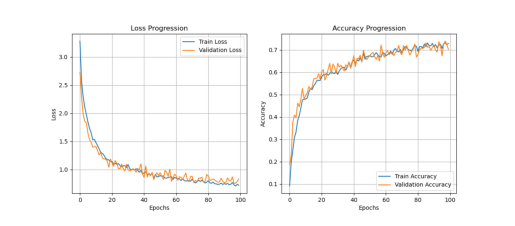

In [33]:
img = mpimg.imread("training_progress2.png")  # Remplacez par le nom de votre image
plt.imshow(img)
plt.axis('off')  # Optionnel, pour enlever les axes
plt.show()